# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [40]:
from enum import Enum
from datetime import datetime
from heapq import heappush
from queue import Queue

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [22]:
sessions = [
    (datetime(2024, 1, 1, 9, 0), datetime(2024, 1, 1, 9, 7)),
    (datetime(2024, 1, 1, 9, 3), datetime(2024, 1, 1, 9, 10)),
    (datetime(2024, 1, 1, 9, 9), datetime(2024, 1, 1, 9, 17)),
    (datetime(2024, 1, 1, 9, 6), datetime(2024, 1, 1, 9, 19)),
]

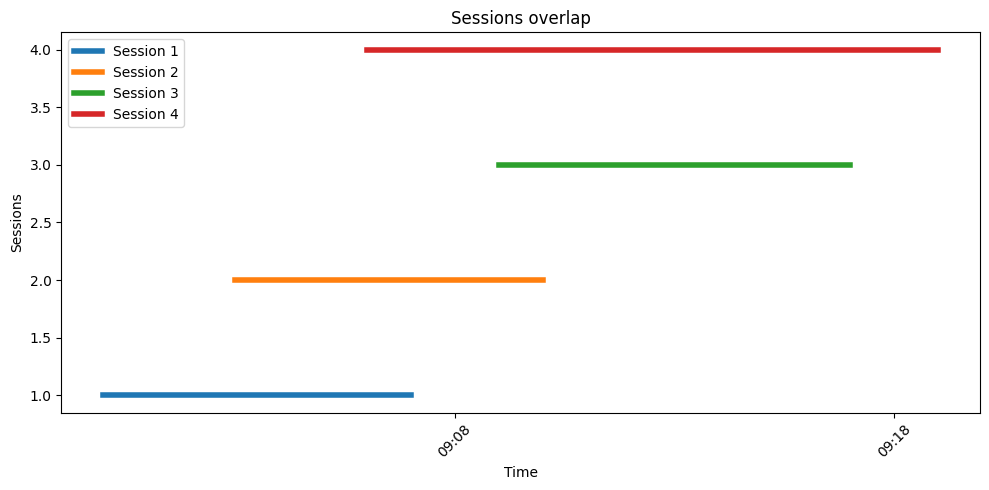

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

for i, (start, end) in enumerate(sessions):
    ax.plot([start, end], [i + 1, i + 1], label=f"Session {i + 1}", linewidth=4)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation=45)

ax.set_xlabel("Time")
ax.set_ylabel("Sessions")
ax.set_title("Sessions overlap")
ax.legend()

plt.tight_layout()
plt.show()

In [44]:
def calculate_composition_end_time(composition_request):
    return composition_request[1] # TODO: it's not always session end time, implement properly

In [52]:
from heapq import heappop

delays = []

timeline = []
for session_start_time, session_end_time in sessions:
    heappush(timeline, (session_start_time, EventType.SESSION_START))
    heappush(timeline, (session_end_time, EventType.SESSION_END))

composition_queue = Queue()
available_composers = 2

while len(timeline) > 0:
    time, event_type = heappop(timeline)

    if event_type == EventType.SESSION_START:
        composition_queue.put((session_start_time, session_end_time))

    while len(composition_queue) and available_composers:
        composition_request = composition_queue.get()
        session_end_time = composition_request[1]
        composition_end_time = calculate_composition_end_time(composition_request)
        delay = composition_end_time - session_end_time
        delays.append(delay)



max_parallel_compositions = 2
composition_queue = []
running_compositions = 0
max_running_compositions = 0
while len(timeline) > 0:
    time, event_type = heappop(timeline)
    if event_type == EventType.SESSION_START:
        if running_compositions < max_parallel_compositions:
            running_compositions += 1
            max_running_compositions = max(running_compositions, max_running_compositions)
        else:
            composition_queue.append(time)
    elif event_type == EventType.SESSION_END:
        running_compositions -= 1

print(max_running_compositions)

KeyboardInterrupt: 